# **Sistema Recomendador**

Este sistema va a tratar de recomendar contenido en función de la tipología de usuario. **En cuánto al nivel de** interacción con la plataforma y **"feedback"** que proveé, **podemos distinguir entre usuarios activos e inactivos**. En este caso solo disponemos de "feedback" explícito, por lo que al hablar de usuarios activos e inactivos, no quiere decir que consuman mucho o poco contenido de la plataforma, sino que nos ofrecen o no una valoración de aquel que consumen. 

**Dentro de los activos podemos distinguir entre usuarios "comunes" y "particulares"** en función del contenido que consumen y como lo valoran. Se considerarán **"particulares" aquellos que consumen un contenido muy poco popular**, o bien lo consumen pero lo valoran de forma bastante diferente a la mayoría de usuarios. En cualquiera de estos casos, el usuario presenta unos gustos poco comunes.

**Este sistema recomendador va a combinar filtrado colaborativo y basado en contenido para adaptarse al tipo de usuario.**

El "grueso" de este sistema recomendador lo va a representar el filtro colaborativo que se basará en un modelo híbrido. Si se dispone de una cantidad de datos suficiente, en este caso de una matriz de "ratings" extensa, este modelo híbrido será capaz de "representar" los gustos de los usuarios, sin embargo, lo hará aprendiendo de aquellos de los cuales disponemos datos, es decir de los activos, y dentro de estos, presentará un sesgo relevante hacia los "comunes". Por tanto, el modelo será un buen estimador de los gustos de la mayoría de usuarios, pero dificilmente de aquellos que hemos catalogado como particulares. En cuanto a los inactivos, el modelo es una buena opción, pues recomendará acorde a los gustos de la mayoría.

Para los usuarios "particulares" se propone un recomendador basado en la similitud con los ítems que el usuario ha consumido y valorado positivamente.

## **Conjuntos de datos: MovieLens**

Se importan los datos a utilizar.

In [1]:
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
from urllib.request import urlretrieve

# Dataset
urlretrieve("https://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
info = zip_ref.read('ml-100k/u.info')

# Users
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')

# Movies
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = ['movie_id', 'title', 'release_date', "video_release_date", "imdb_url"] + genre_cols
movies = pd.read_csv('ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

# Obtenemos el año de la fecha de publicación
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])

# Ratings
ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

## **Matriz de Ratings**

En primer lugar se construye la matriz de "ratings", que será necesaria tanto para la construcción del modelo, como para la determinación de los usuarios "particulares".

In [2]:
user_item_m = ratings.pivot('user_id','movie_id','rating').fillna(0)
user_item_m

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,0.0,0.0,0.0,2.0,0.0,0.0,4.0,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,5.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


En dónde la estrategia a seguir es el reemplazo de los nulos por ceros, para poder trabajar con ellos.

## **Usuarios Particulares**

Se catalogan como usuarios particulares a aquellos para los que aún habiendo valorado una cantidad relevante de películas no se encuentra una cantidad significante de usuarios similares. La similitud entre usuarios se evaluará a partir de la matriz de "ratings", siendo similares aquellos que consumen y valoran de forma similar las mismas películas.

Por tanto, se construye la función para encontrar usuarios similares en función de la matriz de "ratings", pero previamente se define la matriz de similitud entre usuarios.

In [3]:
from sklearn.metrics.pairwise import cosine_similarity

X_user = cosine_similarity(user_item_m)
X_user

array([[1.        , 0.16693098, 0.04745954, ..., 0.14861694, 0.17950788,
        0.39817474],
       [0.16693098, 1.        , 0.11059132, ..., 0.16148478, 0.17226781,
        0.10579788],
       [0.04745954, 0.11059132, 1.        , ..., 0.10124256, 0.13341615,
        0.02655587],
       ...,
       [0.14861694, 0.16148478, 0.10124256, ..., 1.        , 0.1016418 ,
        0.09511958],
       [0.17950788, 0.17226781, 0.13341615, ..., 0.1016418 , 1.        ,
        0.18246466],
       [0.39817474, 0.10579788, 0.02655587, ..., 0.09511958, 0.18246466,
        1.        ]])

Para definir la función que permite encontrar usuarios similares y aplicarla a aquellos que son activos es necesario definir dos criterios:


-   Un umbral de similitud. Dos usuarios se consideran similares si la similitud de coseno entre sus dos vectores de características es superior a 0.4.

-   Un umbral de actividad. Un usuario se considera activo si ha valorado 20 o más películas. 

Estos criterios son configurables y ajustables.



In [4]:
def find_similar_users(user_id, thresh=0.4):
  """
  Ejercicio: Devuelve el listado de usuarios que opinan parecido
  """
  user_list = list(X_user[user_id-1])
  similar_users = [i+1 for i, x in enumerate(user_list) if x>thresh] 
  return len(similar_users)

Se considerarán particulares aquellos usuarios para los que exista uno o ningún usuario similar.

In [5]:
m = ratings.pivot('user_id','movie_id','rating')
active_users     = [i+1 for i in range(len(user_item_m)-1) if m.loc[i+1].count()>50]
particular_users = [i for i in active_users if find_similar_users(i)==1]
print(f"Con estos criterios se tiene un total de {len(active_users)} usuarios activos, de los cuáles {len(particular_users)} son particulares.")

Con estos criterios se tiene un total de 562 usuarios activos, de los cuáles 35 son particulares.


### **Ejemplo de clasificación de usuarios**

En base a estos criterios, podemos ver algunos ejemplos de como nuestro "clasificador" está dividiendo a los usuarios en particulares y comunes.

Se define "score_df", que permitirá comparar la opinión del usuario concreto con la del conjunto.

In [6]:
titles = movies[['title', 'movie_id']]
df     = pd.merge(ratings, titles, on='movie_id')

ratings_df        = pd.DataFrame(df.groupby('movie_id')['rating'].count())
score_df          = pd.merge(ratings_df, pd.DataFrame(df.groupby('movie_id')['rating'].mean()), on='movie_id')
score_df          = score_df.rename(columns={"rating_x":"num_rating","rating_y":"mean_ratings"})
score_df['score'] = score_df['num_rating']*score_df['mean_ratings']

score_df.reset_index(inplace=True)
score_df.head()

,movie_id,num_rating,mean_ratings,score
0,1,452,3.878319,1753.0
1,2,131,3.206107,420.0
2,3,90,3.033333,273.0
3,4,209,3.550239,742.0
4,5,86,3.302326,284.0


In [7]:
print("Los siguientes usuarios son particulares:")
print(f"User_id: {particular_users[0]}")
print(f"User_id: {particular_users[1]}")
print(f"User_id: {particular_users[2]}")
print(f"User_id: {particular_users[3]}")
print(f"User_id: {particular_users[4]}")
print(f"User_id: {particular_users[5]}")
print(f"User_id: {particular_users[6]}")

Los siguientes usuarios son particulares:
User_id: 38
User_id: 89
User_id: 106
User_id: 122
User_id: 154
User_id: 167
User_id: 180


Podemos observar como puntúa el primero de estos usuarios y compararlo con un usuario "común".

El 38 es una buena represantación del tipo de usuario que estamos buscando clasificar en un conjunto diferenciado.

En primer lugar podemos ver cómo ha valorado muy negativamente algunas películas bien o incluso muy bien valoradas por otros usuarios.

In [31]:
ratings[ratings["user_id"]==38][["movie_id","rating"]].merge(score_df.reset_index(), on='movie_id').sort_values("rating", ascending=True).head(20)

,movie_id,rating,index,num_rating,mean_ratings,score
38,257,1.0,256,303,3.745875,1135.0
45,226,1.0,225,166,3.355422,557.0
102,940,1.0,939,32,2.343750,75.0
49,1034,1.0,1033,27,2.518519,68.0
28,450,1.0,449,63,2.396825,151.0
92,400,1.0,399,18,2.722222,49.0
91,717,1.0,716,82,2.817073,231.0
57,526,1.0,525,124,3.830645,475.0
39,145,1.0,144,65,2.446154,159.0
112,1029,1.0,1028,14,2.000000,28.0


Del mismo modo, ha valorado muy positivamente algunas películas que no han tenido demasiado éxito entre los demás usuarios.

In [32]:
ratings[ratings["user_id"]==38][["movie_id","rating"]].merge(score_df.reset_index(), on='movie_id').sort_values("rating", ascending=False).head(20)

,movie_id,rating,index,num_rating,mean_ratings,score
0,95,5.0,94,219,3.812785,835.0
65,70,5.0,69,251,3.661355,919.0
80,418,5.0,417,129,3.581395,462.0
77,313,5.0,312,350,4.245714,1486.0
76,247,5.0,246,5,1.800000,9.0
73,1035,5.0,1034,68,3.161765,215.0
70,1033,5.0,1032,32,2.781250,89.0
68,588,5.0,587,202,3.792079,766.0
67,402,5.0,401,170,3.464706,589.0
66,97,5.0,96,256,3.792969,971.0


Por último, también ha consumido muchas películas muy poco populares.

In [33]:
ratings[ratings["user_id"]==38][["movie_id","rating"]].merge(score_df.reset_index(), on='movie_id').sort_values("num_rating", ascending=True).head(20)

,movie_id,rating,index,num_rating,mean_ratings,score
11,838,2.0,837,4,2.750000,11.0
76,247,5.0,246,5,1.800000,9.0
89,1031,5.0,1030,7,2.285714,16.0
105,35,5.0,34,11,2.181818,24.0
112,1029,1.0,1028,14,2.000000,28.0
110,1032,4.0,1031,16,2.875000,46.0
63,84,5.0,83,18,3.000000,54.0
81,590,1.0,589,18,2.000000,36.0
92,400,1.0,399,18,2.722222,49.0
46,916,5.0,915,18,3.166667,57.0


Ahora se puede comparar con un usuario clasificado como común:

In [35]:
ratings[ratings["user_id"]==1][["movie_id","rating"]].merge(score_df.reset_index(), on='movie_id').sort_values("rating", ascending=False).head(20)

,movie_id,rating,index,num_rating,mean_ratings,score
136,170,5.0,169,121,4.173554,505.0
67,175,5.0,174,208,3.817308,794.0
182,119,5.0,118,4,4.500000,18.0
186,181,5.0,180,507,4.007890,2032.0
191,109,5.0,108,130,3.430769,446.0
77,44,5.0,43,79,3.341772,264.0
75,14,5.0,13,183,3.967213,726.0
74,12,5.0,11,267,4.385768,1171.0
194,223,5.0,222,136,4.198529,571.0
72,108,5.0,107,65,3.076923,200.0


El usuario 1 ha valorado las películas de forma mucho más similar al resto de usuarios. 

## **Creación del recomendador**

### **Modelo Híbrido**

Se construye un modelo híbrido que combina un modelo basado en red neuronal con un modelo de ensamblado de árboles de decisión. 

#### **Modelo Red Neuronal**

Este modelo se encargará de predecir en función únicamente de los feedbacks otorgados por los usuarios.

In [9]:
# Copiamos nuestro conjunto de datos de puntuaciones
df = ratings

# Codificamos los identificadores de usuarios
user_ids = df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
num_users = len(ratings["user_id"].unique())

# Codificamos los identificadores de los items
movie_ids = df["movie_id"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
num_movies = len(ratings["movie_id"].unique())

# Y los incorporamos al conjunto de datos
df["user"] = df["user_id"].map(user2user_encoded)
df["movie"] = df["movie_id"].map(movie2movie_encoded)

In [10]:
# Rango de valores para los ratings
min_rating = 1.0
max_rating = 5.0

# Datos de entrada para nuestra red
x = df[["user", "movie"]].values

# Normalizamoz los ratings entre 0 y 1
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Realizamos la separación entre entrenamiento y validación
idx = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:idx],
    x[idx:],
    y[:idx],
    y[idx:],
)

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class RecommenderNet(keras.Model):
    """
    Clase que codifica un modelo tipo como red de recomendación
    """
    def __init__(self, num_users, num_movies, embedding_size=50, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)

        # Tamaño de nuestros modelos de representación (embeding)
        self.num_users = num_users
        self.num_movies = num_movies

        # Representación de usuarios
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1) # Bias

        # Representación de ítems
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1) # Bias

    # Funcion que se invoca con una entrada tipo
    def call(self, inputs):
        # Usuario
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        # Item
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])

        # Vector de entrada para la red (user + item + bias)
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        x = dot_user_movie + user_bias + movie_bias

        # Aplicamos una función sigmoidea para evaluar el rating (0 a 1.0)
        return tf.nn.sigmoid(x)

Con nuestra estructura neuronal planteada simplemente deberemos instanciar el modelo indicando cual serán las funciones de pérdida (losses) y el optimizador a emplear cuando entrenemos la red.

Seleccionaremos [BinaryCrossEntropy](https://keras.io/api/losses/probabilistic_losses/) como función que evaluará la bondad de nuestro modelo; y [Adam](https://keras.io/api/optimizers/adam/) como función de optimizador en nuestro ejercicio pero estos parámetros pueden variarse siempre teniendo en cuenta las características de nuestro problema a resolver.

In [12]:
model = RecommenderNet(num_users, num_movies)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.001))

Habiendo definido nuestro modelo, solo resta ajustarlo en base a nuestro conjunto de datos.

In [13]:
batch_size = 64 # Numero de muestras por lote a emplear en el entrenamiento
epochs = 5 # Iteraciones sobre el conjunto de datos

# Procedemos a entrenar el modelo
train_output = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1407/1407 [==============================] - 4s 2ms/step - loss: 0.6527 - val_loss: 0.6358
Epoch 2/5
1407/1407 [==============================] - 3s 2ms/step - loss: 0.6275 - val_loss: 0.6285
Epoch 3/5
1407/1407 [==============================] - 3s 2ms/step - loss: 0.6196 - val_loss: 0.6199
Epoch 4/5
1407/1407 [==============================] - 3s 2ms/step - loss: 0.6167 - val_loss: 0.6185
Epoch 5/5
1407/1407 [==============================] - 3s 2ms/step - loss: 0.6163 - val_loss: 0.6169


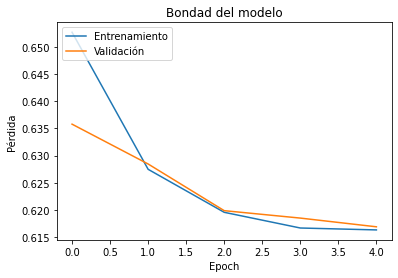

In [14]:
import matplotlib.pyplot as plt

plt.plot(train_output.history["loss"])
plt.plot(train_output.history["val_loss"])
plt.title("Bondad del modelo")
plt.ylabel("Pérdida")
plt.xlabel("Epoch")
plt.legend(["Entrenamiento", "Validación"], loc="upper left")
plt.show()

#### **Modelo "Ensemble" de árboles de decisión**

Este modelo incluirá contexto informativo relativo a usuarios y a películas, por lo que nos ayudará a refinar las predicciones vertidas por el modelo basado en red neuronal.

Probaremos este hecho incluyendo información relativa a la ocupación y sexo de los usuarios de nuestro conjunto de datos de modo que esto ayude a refinar nuestras ponderaciones. Para ello podremos valernos de las funciones [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html?highlight=onehot#sklearn.preprocessing.OneHotEncoder) y [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) de *sklearn*.

In [15]:
from sklearn import preprocessing

# Obtengamos categorías de sexo y occupación para nuestros usuarios
occupation_cols = users["occupation"].unique().tolist()
users[occupation_cols] = preprocessing.OneHotEncoder(handle_unknown='ignore').fit_transform(users["occupation"].values.reshape(-1,1)).toarray()
users['sex'] = preprocessing.LabelEncoder().fit_transform(users['sex'])

# Obtengamos nuestro conjunto de datos de entrenamiento
x = ratings[['user_id', 'movie_id']]
y = ratings['rating']

selected_cols = occupation_cols + ["user_id", "age","sex"]
x = x.merge(users[selected_cols], on=["user_id","user_id"]).merge(movies[genre_cols + ["movie_id"]], on=["movie_id","movie_id"])
x

,user_id,movie_id,technician,other,writer,executive,administrator,student,lawyer,educator,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,305,242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,6,242,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,234,242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,63,242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,863,1679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,1,0,0
99996,863,1678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
99997,863,1680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
99998,896,1681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
idx = int(0.9 * x.shape[0])
x_train, x_val, y_train, y_val = (
    x[:idx],
    x[idx:],
    y[:idx],
    y[idx:],
)

In [17]:
import xgboost as xgb

# Configuramos el modelo en su versión de regressión
model_xgb = xgb.XGBRegressor(objective='reg:squarederror')
model_xgb.fit(x_train, y_train)

# Realizamos las prediciones sobre el conjunto de validación
pred = model_xgb.predict(x_val)
rmse = np.sqrt(np.mean((pred - y_val.to_numpy())**2))
print(f'RMSE sobre el rating basado en el contenido = {rmse}')

RMSE sobre el rating basado en el contenido = 1.1299110124868725


#### **Combinación de los dos modelos**

In [18]:
def hybrid_recommender(user_id, num=10):
  """
  Ejercicio: combinar dos de los modelos anteriormente entrenados para poder así 
  combinar los resultados y mejorar nuestras predicciones. Puede ser una 
  combinación sencilla que simplemente pondere ambas puntuaciones.
  """
  # Peliculas vistas
  seen_movies = ratings[ratings["user_id"] == user_id]

  # Películas no vistas
  not_seen = movies[~movies["movie_id"].isin(seen_movies["movie_id"].values)]["movie_id"].tolist()

  # MODELO NEURONAL NETWORK
  not_seen_nn =  list(set(not_seen).intersection(set(movie2movie_encoded.keys())))
  not_seen_nn = [[movie2movie_encoded.get(x)] for x in not_seen_nn]
  ## User
  encoded_id = user2user_encoded.get(10)
  ## Input data para el modelo de nn
  input_data  = np.hstack(([[encoded_id]] * len(not_seen_nn), not_seen_nn))
  ## Predictions
  pred_ratings = model.predict(input_data).flatten()
  pred_ratings = pred_ratings*4+1
  movie_id = [movie_encoded2movie.get(not_seen_nn[i][0]) for i in range(len(not_seen))]
  predictions = movies[movies["movie_id"].isin(movie_id)][["title","movie_id"]]
  predictions["rate"] = list(pred_ratings)
  predictions

  # MODELO XGBOOST
  user_data = users[users["user_id"] == user_id][selected_cols]
  movie_data = movies[movies["movie_id"].isin(not_seen)][genre_cols + ["movie_id"]]
  ## Obtengamos nuestro conjunto de datos de entrenamiento
  x_data = movie_data
  x_data["user_id"] = user_id
  x_data = x_data.merge(user_data, on=["user_id","user_id"])
  ## Obtenemos las predicciones
  pred_xgb = model_xgb.predict(x_data[x.columns])
  ret_df = pd.DataFrame({"movie_id" : movie_data["movie_id"].values, "score" : pred_xgb})

  #COMBINACIÓN DE LOS MODELOS
  ret_df = ret_df.merge(predictions, on=["movie_id","movie_id"])
  ret_df["suma"] = (ret_df["score"]+ret_df["rate"])/2
  top_rated = ret_df.sort_values(by=['suma'], ascending = False).head(num)["movie_id"]
  top_rated

  # Devolvemos la lista de las películas mejor valoradas
  return movies[movies["movie_id"].isin(top_rated)]["title"]

In [19]:
hybrid_recommender(5)

11           Usual Suspects, The (1995)
63     Shawshank Redemption, The (1994)
177                 12 Angry Men (1957)
186      Godfather: Part II, The (1974)
190                      Amadeus (1984)
222                  Sling Blade (1996)
284               Secrets & Lies (1996)
301            L.A. Confidential (1997)
482                   Casablanca (1942)
602                  Rear Window (1954)
Name: title, dtype: object

### **Modelo basado en contenido**

A los usuarios "particulares" se les recomendarán películas similares a aquellas que han valorado positivamente. 

Para determinar la similitud entre dos películas nos basaremos en su pertenencia al mismo o a los mismos géneros. Lo ideal sería contar con más información para cada película como actores, director....

Se presupone que toda esta información estará recogida para un sistema de recomendación más "profesional", de modo que la sugerencia sería mucho más refinada.

#### **Matriz de similitud**

Se genera la matriz de similtud para las películas.

In [20]:
films_sim = cosine_similarity(movies[genre_cols])
films_sim = pd.DataFrame(films_sim)
films_sim.columns = movies['movie_id'].values
films_sim.index += 1
films_sim

,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
1,1.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.57735,0.000000
2,0.000000,1.000000,0.577350,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.816497,0.000000,0.000000,0.000000,0.000000,0.000000,0.408248,0.000000,0.00000,0.000000
3,0.000000,0.577350,1.000000,0.000000,0.577350,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.707107,0.000000,0.000000,0.000000,0.000000,0.000000,0.707107,0.000000,0.00000,0.000000
4,0.333333,0.333333,0.000000,1.000000,0.333333,0.577350,0.408248,0.666667,0.577350,0.408248,...,0.408248,0.577350,0.577350,0.577350,0.577350,0.577350,0.000000,0.408248,0.57735,0.577350
5,0.000000,0.333333,0.577350,0.333333,1.000000,0.577350,0.408248,0.333333,0.577350,0.408248,...,0.408248,0.577350,0.577350,0.577350,0.577350,0.577350,0.408248,0.408248,0.00000,0.577350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1678,0.000000,0.000000,0.000000,0.577350,0.577350,1.000000,0.707107,0.577350,1.000000,0.707107,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.707107,0.00000,1.000000
1679,0.000000,0.408248,0.707107,0.000000,0.408248,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.500000,0.00000,0.000000
1680,0.000000,0.000000,0.000000,0.408248,0.408248,0.707107,0.500000,0.408248,0.707107,0.500000,...,0.000000,0.707107,0.707107,0.707107,0.707107,0.707107,0.500000,1.000000,0.00000,0.707107
1681,0.577350,0.000000,0.000000,0.577350,0.000000,0.000000,0.000000,0.577350,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000


#### **Función para encontrar películas similares**

In [21]:
def find_similar(movie_id):
  # Obtenemos las métricas para las peliculas
  m_list = films_sim.loc[movie_id].tolist()
  # Filtramos por aquellas simialres
  similar_movies = [i+1 for i,x in enumerate(m_list) if x == 1]
  # Devolvemos los titulos
  return movies[movies["movie_id"].isin(similar_movies)][["movie_id","title"] + genre_cols]

#### **Función para encontrar las películas favoritas del usuario**

In [22]:
def favorite_movies(user_id:int, num=10):
  """
  Devolveremos los 10 títulos mejor valorados por un usuario
  """
  # Obtenemos las películas ya vistas por el usuario
  rated = ratings[ratings["user_id"] == user_id]
  
  # Las películas valoradas por este
  rated_info = pd.merge(rated, titles, on='movie_id')[["movie_id","title","rating"]]
  return rated_info.sort_values(by='rating', ascending=False).head(num)

#### **Creación del modelo**

In [28]:
def content_based_recommender(user_id, num=10):
   """
   Devolvemos el numero de películas indicadas a recomendar que el usuario no haya visto y sean 
   similares a las películas vistas y puntuadas con un rating alto por el mismo usuario.
   """
   # Películas mejor puntuadas por el usuario
   fav_movies = favorite_movies(user_id, 10)

   # Películas no vistas por el usuario (candidatas)
   already_seen = ratings[ratings["user_id"] == user_id]["movie_id"]
   not_seen = movies.merge(already_seen.drop_duplicates(), on=['movie_id','movie_id'], how='left', indicator=True)
   not_seen_id = not_seen[not_seen['_merge'] == 'left_only']["movie_id"]

   # Para cada película buscamos en su matriz de similitud lo títulos más similares, 
   # su máxima similitud con las películas valoradas y nos quedamos con las num primeras
   value_matrix = films_sim[fav_movies["movie_id"].to_list()]
   movies_to_recommend = value_matrix.loc[not_seen_id.to_list()]
   movies_to_recommend['average'] = movies_to_recommend.mean(numeric_only=True, axis=1)
   chosen_movies = movies_to_recommend['average'].sort_values(ascending=False).head(num).reset_index()["index"].to_list()

   return titles[titles["movie_id"].isin(chosen_movies)]

### **Modelo Final**

En función del tipo de usuario se le recomendará empleando uno u otro modelo.

In [25]:
def final_recommender(user_id, num=10):

  if m.loc[user_id].count()>50:
    if find_similar_users(user_id)==1:
      return content_based_recommender(user_id)
    else:
      return hybrid_recommender(user_id)
  else:
      return hybrid_recommender(user_id)

In [30]:
final_recommender(1)

284               Secrets & Lies (1996)
301            L.A. Confidential (1997)
317             Schindler's List (1993)
407               Close Shave, A (1995)
426        To Kill a Mockingbird (1962)
482                   Casablanca (1942)
602                  Rear Window (1954)
656    Manchurian Candidate, The (1962)
704          Singin' in the Rain (1952)
708            Strictly Ballroom (1992)
Name: title, dtype: object

### **Conclusión Final**

Comentar como conlcusión final dos hechos respecto al filtro para usuarios "particulares":

- Como ya se comentó, sería necesario disponer de más contexto informativo alrededor de las películas para que el recomendador gozase de una buena fiabilidad.

- Por otro lado, lo ideal sería optar por un recomendador basada en modelo, generando por ejemplo una matriz de "embeding" para las películas, de modo que se pueda realizar una abstracción de la información de las mismas así como reducir la dimensionalidad, evitando cargar siempre con esta matriz informativa.

Se realizó de este modo para emplear tanto un recomendador basado en modelos como otro que no.